In [1]:
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

## Variational Inference

Variational inference provides an analytical approximation 

$$q(z)\approx p(z|x)$$ 

of the posterior probability distribution $p(z|x)$, over a set of unobserved variables $Z$ and the observed data $X$. 

The parameters $\nu$ of the **variational distribution** $q(z;\nu)$ are optimized over a restricted family of known distributions (usually Gaussian distributions) by minimizing the dissimilarity between $q$ and $p$. The measure of similarity between the two distributions is the **Kullback-Leiber divergence**

$$\text{KL}(q||p):=-\sum_Z q(z;\nu) \log\Big(\frac{p(z|x)}{q(z;\nu)}\Big).$$

and the minimization problem 

$$\nu^*=\arg\min_\nu \text{KL}(q||p),$$

involves the computation of the intractable posterior $p(z|x)$. Now notice that the model evidence satisfies the following property

$$\log p(x) = \text{KL}(q||p)+\mathbb{E}_q [\log p(x,z)-log(q;\nu)]$$

and that it is always constant with respect to the variational parameters $\nu$. So the above optimization problem can be solved equivalently by minimizing the **Evidence Lower Bound (ELBO) loss** 

$$\text{ELBO}(\nu)=\mathbb{E}_q [\log p(x,z)-\log(q;\nu)],$$

which only contains tractable terms.

The first term in the ELBO loss encouranges $q$ to place its probability mass on the MAP estimate, while the second favours entropy on the mass, to avoid its concentration in a single location.

<div> 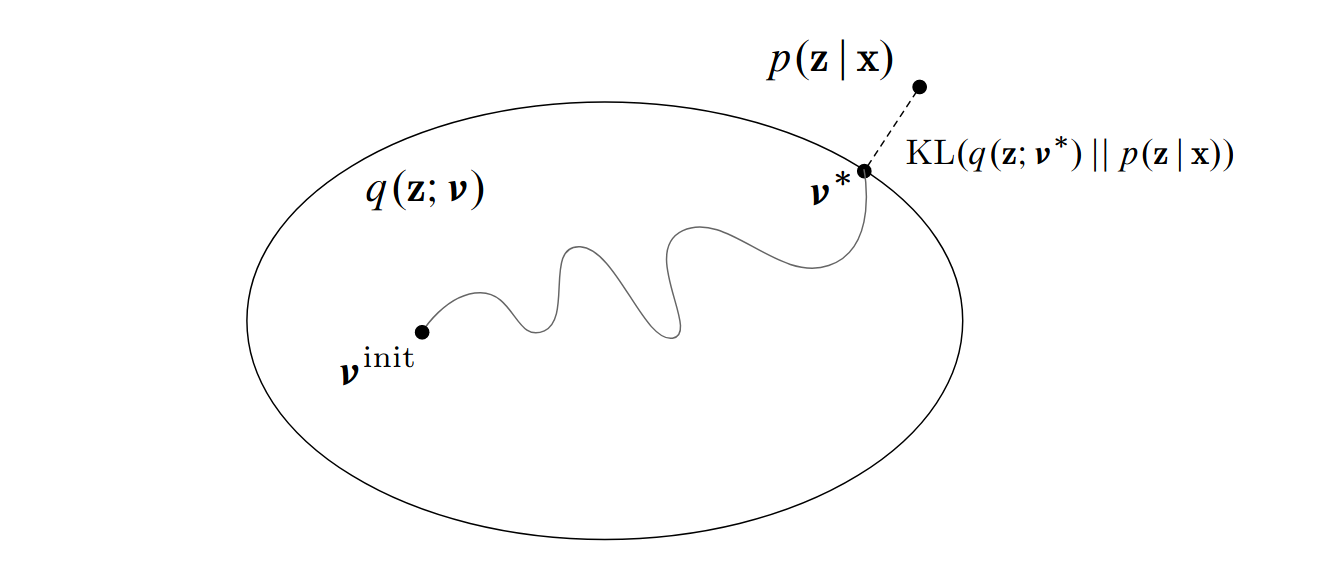</div>
<div align="center" style="color:darkblue">D. Blei, R. Ranganath, S. Mohamed, "Variational Inference: Foundations and Modern Methods". (2016)</div>

## model + guide 

Stochastic variational inference is implemented as a pyro class

```
SVI(model, guide, optim, loss)
```

whose arguments are a **model** function, a **guide** function, a pytorch optimizer and
the ELBO loss function.

`model()` is a stochastic function that implements the generative process and is conditioned on the observations.

`guide()` represents the variational distribution $q(z;\nu)$, so it needs to provide a valid joint probability density over all the latent random variables in the model.

Keep in mind that these two methods:
- should always take the same arguments
- should both sample the parameters that have to be inferred and use the same names for them, but not necessarily the same distributions

For example

```
def model(data):
    pyro.sample("theta", Uniform(-1.,1.))
    ...
   
def guide(data):
    pyro.sample("theta", Normal(0.,1.))
    ... 
```

The **optimization step** is performed by calling `step()` on the training batch data:

```
optim = Adam({lr:0.02}) 
loss = ELBO_loss()
svi = SVI(model, guide, optim, loss)

for step in range(n_steps):
    for batch_data in training_data:
        svi.step(batch_data)
```

The name "stochastic" is due to the batch training technique.

### Rain in Australia bayesian regression

In this example we are using a dataset containing daily weather observations in Australian weather stations: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

We are going to use several explanatory variables $x_i$ to predict the outcome of the response variable $y$. Our goal is to fit a function

$$ y=w_0 x_0+\ldots+w_k x_k + b + \epsilon$$

to the given dataset $D=\{(x_i,y_i)\}_{i=1,\ldots,N}$, by providing posterior probability distributions for the learnable parameters, instead of single point estimates. 

The **learnable parameters** are the weights matrix $w$ and the bias vector $b$, while $\epsilon$ is the **observation noise**. 

In [2]:
# load data from csv and remove NA values
data = pd.read_csv("data/weatherAUS.csv").dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 5939 to 139112
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cl

The target variable in our model is the amount of rainfall recorded for the day in Sydney and we wish to infer the parameters corresponding to the following predictors

$$
\text{Rainfall}=w_0\cdot\text{MinTemp}+w_1\cdot\text{MaxTemp}+w_2\cdot\text{Humidity9am}+\\
w_3\cdot\text{Humidity3pm}+w_4\cdot\text{Cloud9am}+w_5\cdot\text{Cloud3pm}+b + \epsilon
$$

In [3]:
# extract Sydney data 
sydney_data = data.loc[data["Location"]=="Sydney"]

# choose predictors and response for this model
mlr_data = sydney_data[["Rainfall","MinTemp","MaxTemp","Humidity9am",
                        "Humidity3pm","Cloud9am","Cloud3pm"]]

print("n_observations =", len(mlr_data))
mlr_data.head()

n_observations = 1690


,Rainfall,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm
30487,0.2,12.9,20.3,70.0,57.0,3.0,1.0
30488,0.0,13.3,21.5,75.0,58.0,2.0,5.0
30489,0.0,15.3,23.0,70.0,63.0,1.0,4.0
30493,0.2,12.9,26.7,73.0,56.0,1.0,5.0
30494,0.0,14.8,23.8,76.0,69.0,2.0,7.0


We need to convert data into torch tensors before passing it to our pyro model `sydney_mlr_model`.

In [4]:
# dataset columns to torch tensors
rain = torch.tensor(mlr_data["Rainfall"].values, dtype=torch.float)
predictors = torch.stack([torch.tensor(mlr_data[column].values, dtype=torch.float)
                           for column in ["MinTemp","MaxTemp","Humidity9am",
                                         "Humidity3pm","Cloud9am","Cloud3pm"]], 1)

Now we perform a train-test split on the data:
- **train data** - 80% of the observations will be used to perfom inference on our model
- **test data** - the remaining 20% will be used for testing the correctness of posterior predictions 

In [5]:
k = int(0.8 * len(mlr_data))
x_train, y_train = predictors[:k], rain[:k]
x_test, y_test = predictors[k:], rain[k:]

print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([1352, 6]) 
y_train.shape = torch.Size([1352])

x_test.shape = torch.Size([338, 6]) 
y_test.shape = torch.Size([338])


We set a normal prior on $w$, a Log-Normal on the bias term $b$ and a uniformly distributed std for the gaussian noise on $\hat{y}$

\begin{align*}
w&\sim\mathcal{N}(0,1)\\
b&\sim\text{LogNormal}(0,1)\\
\hat{y}&= w x + b\\
\sigma &\sim \mathcal{U}(0,0.05)\\
y &\sim \mathcal{N}(\hat{y},\sigma^2).
\end{align*}

Then we define the family of posterior distributions, by setting a Gamma distribution on $w$ and a Log-Normal on $b$, and run SVI inference on $(x,y)$ data.

Notice the prior distribution on the bias term makes this regression problem analytically intractable.

In [6]:
# modelling rain in terms of the predictors
def sydney_model(predictors, rain):
    n_observations, n_predictors = predictors.shape

    # sample weights
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors), 
                                        torch.ones(n_predictors)))
    b = pyro.sample("b", dist.LogNormal(torch.zeros(1), torch.ones(1)))

    yhat = (w*predictors).sum(dim=1) + b

    # sample observations noise
    sigma = pyro.sample("sigma", dist.Uniform(0., 1.))

    # condition on the observations
    with pyro.plate("rain", len(rain)):
        pyro.sample("obs", dist.Normal(yhat, sigma), obs=rain)


def sydney_guide(predictors, rain=None):
    n_observations, n_predictors = predictors.shape

    w_loc = pyro.param("w_loc", torch.rand(n_predictors), constraint=constraints.positive)
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), 
                         constraint=constraints.positive)

    w = pyro.sample("w", dist.Gamma(w_loc, w_scale))

    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), constraint=constraints.positive)

    b = pyro.sample("b", dist.LogNormal(b_loc, b_scale))


pyro.clear_param_store()

sydney_svi = SVI(model=sydney_model, guide=sydney_guide, 
              optim=optim.ClippedAdam({'lr' : 0.01}), 
              loss=Trace_ELBO()) 

for step in range(2000):
    loss = sydney_svi.step(x_train, y_train)/len(x_train)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 2086.3605838380095
Step 100 : loss = 103.4847946688092
Step 200 : loss = 347.08613425409476
Step 300 : loss = 47.400843437430424
Step 400 : loss = 1055.3710670858268
Step 500 : loss = 313.7126691625316
Step 600 : loss = 832.0430700469476
Step 700 : loss = 222.6551107298693
Step 800 : loss = 46.192370178431446
Step 900 : loss = 225.57117112465863
Step 1000 : loss = 326.49223497933184
Step 1100 : loss = 1675.4066291596057
Step 1200 : loss = 49.83862483986383
Step 1300 : loss = 38.52301673829203
Step 1400 : loss = 155.43462748904906
Step 1500 : loss = 5857.294730070251
Step 1600 : loss = 1446.6998590696494
Step 1700 : loss = 116.65231037845273
Step 1800 : loss = 412.3619211309055
Step 1900 : loss = 449.74634131066193


We can extract the inferred parameters as follows.

In [7]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

# w_i and b posterior mean
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w_0 = 0.19547413
w_1 = 0.18661861
w_2 = 0.22185482
w_3 = 0.21882056
w_4 = 0.39172369
w_5 = 0.33606610
b = -4.17506599


**Posterior predictive distribution**

We can use the `Predictive` utility class, corresponding to the posterior predictive distribution, to evaluate our model on test data. Here we compute some summary statistics (mean, std and qualtiles) on $100$ samples from the posterior predictive:

In [8]:
# print latent params quantile information
def summary(samples):
    stats = {}
    for par_name, values in samples.items():
        marginal = pd.DataFrame(values)
        percentiles=[.05, 0.5, 0.95]
        describe = marginal.describe(percentiles).transpose()
        stats[par_name] = describe[["mean", "std", "5%", "50%", "95%"]]
    return stats

# define the posterior predictive
predictive = Predictive(model=sydney_model, guide=sydney_guide, num_samples=100,
                        return_sites=("w","b","sigma"))

# get posterior samples on test data
svi_samples = {k: v.detach().numpy() for k, v in predictive(x_test, y_test).items()}

# show summary statistics
for key, value in summary(svi_samples).items():
    print(f"Sampled parameter = {key}\n\n{value}\n")

Sampled parameter = w

       mean       std            5%       50%       95%
0  0.003707  0.007860  1.064058e-08  0.000243  0.018178
1  0.002320  0.004549  5.644288e-09  0.000236  0.009828
2  0.033005  0.065437  6.801664e-08  0.002241  0.159085
3  0.020273  0.048653  2.728870e-07  0.004579  0.076322
4  0.336199  0.532804  3.745800e-04  0.123925  1.679710
5  0.120576  0.194604  1.513461e-05  0.023603  0.546003

Sampled parameter = b

       mean       std        5%       50%       95%
0  0.018245  0.010315  0.005877  0.015903  0.038827

Sampled parameter = sigma

       mean       std        5%       50%       95%
0  0.504534  0.280446  0.058381  0.544209  0.929148



The most known metrics for comparing different regression models are the **Mean Absolute Error** (MAE)

$$\frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|$$

and the **Mean Squared Error** (MSE)

$$\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2,$$

where $n$ is the number of observations, $y$ are the true values `y_test` and $\hat{y}$ are the predicted values `y_pred`.

In [9]:
# compute predictions using the inferred paramters
y_pred = (inferred_w * x_test).sum(1) + inferred_b

print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())

MAE = 29.283140182495117
MSE = 923.4408569335938


### Bayesian logistic regression

Logistic regression is a **classification algorithm**: it predicts the probability that some given input $x$ belongs to a certain class $y$. 
This algorithm combines a multiple linear regression $\mathbf{w}^t\cdot \mathbf{x}$ on the predictors with a non-linearity on the output, corresponding to the sigmoid function $$\sigma(z)=\frac{1}{1+e^{-z}}, $$ which maps predictions to probability distributions.
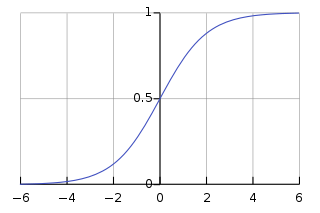
<div align="center" style="color:darkblue">https://en.wikipedia.org/wiki/Sigmoid_function</div>

Our goal in Bayesian logistic regression is to learn the conditional probability 

$$P(y|\mathbf{x},\mathbf{w}) = \sigma(\mathbf{w}^t\cdot\mathbf{x})=\frac{1}{1+e^{-(\mathbf{w}^t\cdot\mathbf{x})}}$$

by training the model on a dataset of labeled examples $(\mathbf{x},y)$.







**Predicting tomorrow's rain**

Suppose we wish to predict the binary label `RainTomorrow` from the Australian weather dataset. First, we need to replace the original labels `Yes`/`No` with boolean classification labels.

In [10]:
# select Sydney data
sydney_data = data.loc[data["Location"]=="Sydney"]

# replace labels with boolean values
print(sydney_data["RainTomorrow"].unique(), end=" ---> ")
sydney_data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)
print(sydney_data["RainTomorrow"].unique())

# classification labels
labels = torch.tensor(sydney_data["RainTomorrow"].values, dtype=torch.double)

['No' 'Yes'] ---> [0 1]


/home/eferos93/github/statistical-machine-learning/venv/lib/python3.6/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Now we specify the set of predictors for our model and normalize the data, in order to guarantee better convergence properties.

In [11]:
# select predictors
df = sydney_data[["Rainfall","Humidity3pm","Cloud3pm","WindSpeed3pm",
                  "Evaporation","Pressure3pm"]]
df.head()

,Rainfall,Humidity3pm,Cloud3pm,WindSpeed3pm,Evaporation,Pressure3pm
30487,0.2,57.0,1.0,26.0,3.0,1025.6
30488,0.0,58.0,5.0,28.0,6.6,1022.4
30489,0.0,63.0,4.0,19.0,5.6,1017.8
30493,0.2,56.0,5.0,24.0,3.8,1015.0
30494,0.0,69.0,7.0,26.0,6.8,1014.7


In [12]:
# dataset normalization
df = (df-df.min())/(df.max()-df.min())
df.head()

,Rainfall,Humidity3pm,Cloud3pm,WindSpeed3pm,Evaporation,Pressure3pm
30487,0.002119,0.552941,0.125,0.521739,0.163043,0.752381
30488,0.000000,0.564706,0.625,0.565217,0.358696,0.676190
30489,0.000000,0.623529,0.500,0.369565,0.304348,0.566667
30493,0.002119,0.541176,0.625,0.478261,0.206522,0.500000
30494,0.000000,0.694118,0.875,0.521739,0.369565,0.492857


Finally we stack the dataframe columns in a single torch tensor and perform a train-test split on the data.

In [13]:
# torch tensor of features
features = torch.stack([torch.tensor(df[colname].values) for colname in df], dim=1)

# train-test split
k = int(0.8 * len(sydney_data))
x_train, y_train = features[:k], labels[:k]
x_test, y_test = features[k:], labels[k:]

print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([1352, 6]) 
y_train.shape = torch.Size([1352])

x_test.shape = torch.Size([338, 6]) 
y_test.shape = torch.Size([338])


Now we can define our pyro model and perform inference on the training data. Notice that we sample classification labels from a **Bernoulli distribution**, because we need a binary outcomes.

torch.Size([1352])
torch.Size([1352])
Step 0 : loss = 1.1652361096418853
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])
torch.Size([1352])


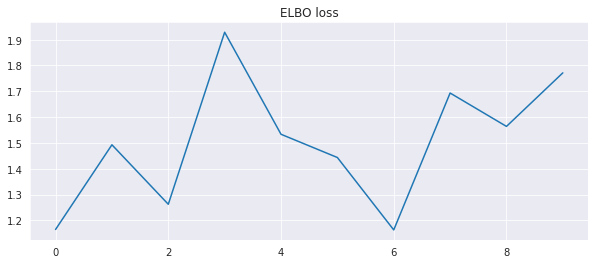

In [14]:
# delete previously inferred params from pyro.param_store()
pyro.clear_param_store()

def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    b = pyro.sample("b", dist.Normal(0.,1.))
    
    # non-linearity
    yhat = torch.sigmoid((w*x).sum(dim=1) + b)
    print(yhat.shape)
    with pyro.plate("data", n_observations):
        # sampling 0-1 labels from Bernoulli distribution
        y = pyro.sample("y", dist.Bernoulli(yhat), obs=y)
    print(y.shape)
        
def log_reg_guide(x, y=None):
    
    n_observations, n_predictors = x.shape
    
    w_loc = pyro.param("w_loc", torch.rand(n_predictors))
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), 
                         constraint=constraints.positive)
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
    
    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), 
                         constraint=constraints.positive)
    b = pyro.sample("b", dist.Normal(b_loc, b_scale))

    
log_reg_svi = SVI(model=log_reg_model, guide=log_reg_guide, 
              optim=optim.ClippedAdam({'lr' : 0.0002}), 
              loss=Trace_ELBO()) 

losses = []
for step in range(10):
    loss = log_reg_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        
fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss");

Our Bayesian logistic regression function returns a probability score between 0 and 1 on each input point $x$, which is the output of the sigmoid function. 

In order to map this value to a discrete class, `predict_class()` uses a **threshold value** of 0.5 to decide whether $x$ belongs to class $0$ or $1$. 

In [15]:
w = pyro.get_param_store()["w_loc"]
b = pyro.get_param_store()["b_loc"]

def predict_class(x):
    out = torch.sigmoid((w * x).sum(dim=1) + b)
    return (out>0.5)


Finally, we can compute the **test accuracy** of our model, which is the percentage of correct predictions on test data.

In [16]:
correct_predictions = (predict_class(x_test) == y_test).sum().item()

print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

test accuracy = 26.04%


The Bayesian logistic regression model can be easily extended to the **multi-class classification** case by using a Categorical distribution instead of a Bernoulli one.